In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import glob
import gzip
import scipy
import time
import gc

import sklearn.cluster
  
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

# from openTSNE import TSNE as openTSNE
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

import os


In [4]:
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/Volumes/JD-SSD/bees/beeresults2019/'
comb_contents_dir = '/Volumes/JD-SSD/bees/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
#%cd 'directory-with-py-files'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

/Users/jacob/Seafile/Bees_sharedcodes/heat_stress_2019/definitions_2019.py:30: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

In [5]:
dfqueen = pd.read_hdf(resultsdir+'queentrajectory_alldays.hdf')

In [6]:
controldays = bd.heatdays[1:] - 1
treatmentdays = bd.heatdays[1:]
control_day_with_blocking = 86 # so I can remember to treat this one differently
treatment_day_nocontrol = 87
controldays = np.delete(controldays,np.where(controldays==control_day_with_blocking)[0])
controldays,treatmentdays

(array([78, 80, 92, 95]), array([79, 81, 87, 93, 96]))

# Per hour trajectories and plots

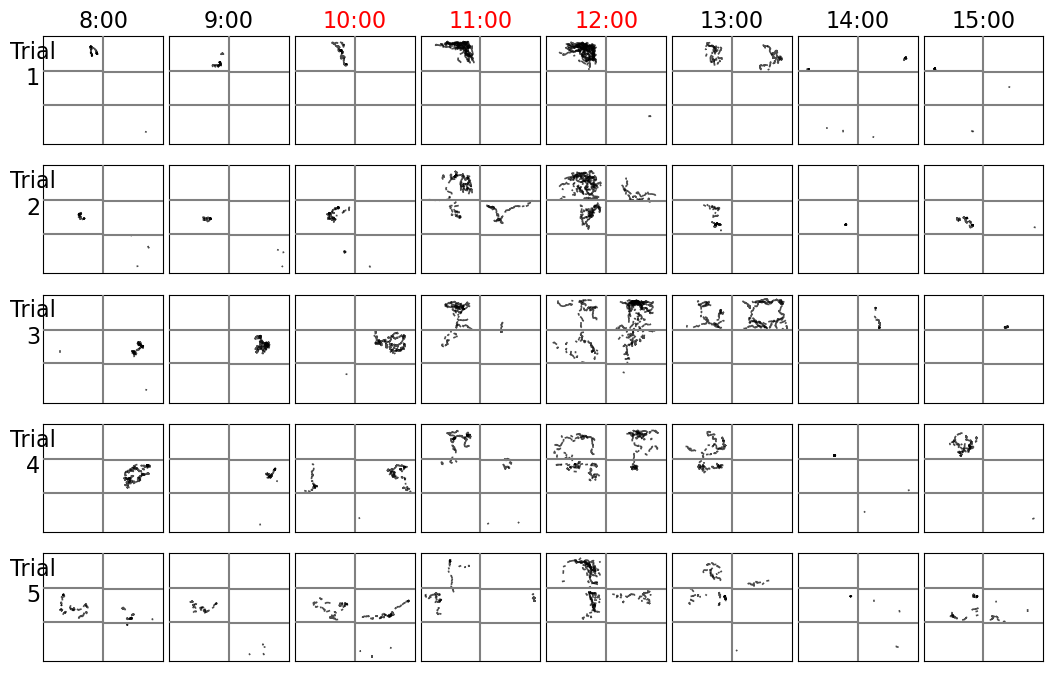

In [9]:
days_to_show = treatmentdays
hournums = np.arange(8,16)
bee_uid = 0 # for the queen
framesperhour = 3*60*60

f,ax = plt.subplots(len(days_to_show),len(hournums),sharex=True,sharey=True)
basesize=1.25
f.set_size_inches(ax.shape[1]*basesize,ax.shape[0]*basesize)
f.set_facecolor('white')

# set the axes orientations
for a in ax.flatten():
    bp.createnewimage(size=0,f=f,ax=a)
    a.set_xticks([])
    a.set_yticks([])        

i=0
daynum = days_to_show[i]
for i,daynum in enumerate(days_to_show):
    ax[i,0].set_ylabel('Trial\n'+str(i+1),rotation=0,fontsize=16,color='k')

    dfday = dfqueen[dfqueen['daynum']==daynum]
    
    # # load the comb structure and plot 
    # comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
    # for a in ax[i]:
    #     bp.showcomb(comb,ax=a)

    for h,a in zip(hournums,ax[i]):
        # get framenums in order to select data
        startframe = framesperhour*h
        endframe = framesperhour*(h+1)
        dfsel = dfday[(dfday['uid']==bee_uid)&(dfday['framenum']>=startframe)& (dfday['framenum']<endframe)]    
        bp.showframe(ax=a,color='grey')
        bp.plotbee_xy(dfsel['x'],dfsel['y'],dfsel['camera'],ax=a,rasterized=True,s=12)

# labels and formatting
for h,a in zip(hournums,ax[0]):
    color = ('r' if h in [10,11,12] else 'k')
    a.set_title(str(h)+':00',fontsize=16,color=color)

plt.subplots_adjust(wspace=0.05)
plt.savefig('../image-output/queentraj-heat.pdf')
plt.show()

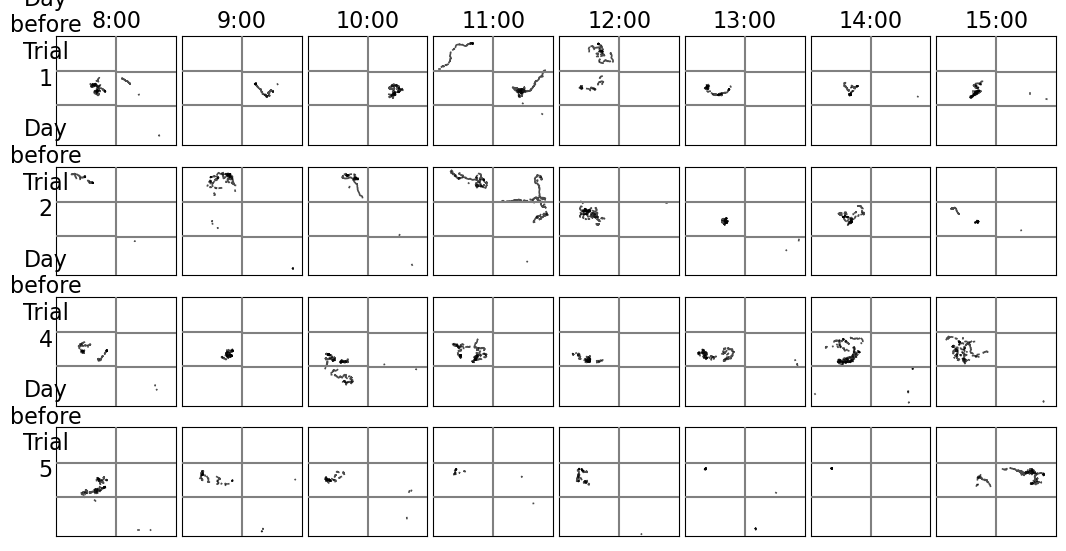

In [11]:
days_to_show = controldays
labelnums = [1,2,4,5]
hournums = np.arange(8,16)
bee_uid = 0 # for the queen
framesperhour = 3*60*60

f,ax = plt.subplots(len(days_to_show),len(hournums),sharex=True,sharey=True)
basesize=1.25
f.set_size_inches(ax.shape[1]*basesize,ax.shape[0]*basesize)
f.set_facecolor('white')

# set the axes orientations
for a in ax.flatten():
    bp.createnewimage(size=0,f=f,ax=a)
    a.set_xticks([])
    a.set_yticks([])        

i=0
daynum = days_to_show[i]
for i,daynum in enumerate(days_to_show):
    ax[i,0].set_ylabel('Day\nbefore\nTrial\n'+str(labelnums[i]),rotation=0,fontsize=16,color='k')

    dfday = dfqueen[dfqueen['daynum']==daynum]

    # # load the comb structure and plot 
    # comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
    # for a in ax[i]:
    #     bp.showcomb(comb,ax=a)

    for h,a in zip(hournums,ax[i]):
        # get framenums in order to select data
        startframe = framesperhour*h
        endframe = framesperhour*(h+1)
        dfsel = dfday[(dfday['uid']==bee_uid)&(dfday['framenum']>=startframe)& (dfday['framenum']<endframe)]    
        bp.showframe(ax=a,color='grey')
        bp.plotbee_xy(dfsel['x'],dfsel['y'],dfsel['camera'],ax=a,rasterized=True,s=12)

# labels and formatting
for h,a in zip(hournums,ax[0]):
    color = ('r' if h in [10,11,12] else 'k')
    color = 'k'
    a.set_title(str(h)+':00',fontsize=16,color=color)

plt.subplots_adjust(wspace=0.05)
plt.savefig('../image-output/queentraj-control.pdf')
plt.show()

# Plot metrics for the queen

## calculate time outside

In [58]:
dfhour = pd.read_hdf(resultsdir+'queendf_'+'dayhour'+'_all.hdf')

# assign integer hournumber, starting from the first day loaded
dfhour['HourInteger'] = dfhour['Day number']*24 + dfhour['Hour']

# Calculate time outside and transitions using 1-minute data, and then save this back in the dataframe
df1min = pd.read_hdf(resultsdir+'queendf_'+'day1min'+'_all.hdf')
df5min = pd.read_hdf(resultsdir+'queendf_'+'day5min'+'_all.hdf')
# assign integer timediv number
df1min['TimeInteger'] = df1min['Day number']*1440 + df1min['timedivision']
df5min['TimeInteger'] = df5min['Day number']*288 + df5min['timedivision']

# calculate outside, and save it back in the 1 min dataframe
obs_threshold=5
exitdistthreshold=1500
for daynum in range(bd.numdays):
    
    # single day df of the 1 minute data
    dfday = df1min[df1min['Day number']==daynum]
    
    day_uids, day_ages, all_inhive, bee_obs, bee_exitdist,_ = dfunc.get_inout_estimates(
        dfday, obs_threshold=obs_threshold, exitdistthreshold=exitdistthreshold,numtimedivs=1440)
    
    
    # calculations trip durations
    wentoutside = np.insert(np.diff(all_inhive,axis=1)==-1,0,0,axis=1)
    cameback = np.insert(np.diff(all_inhive,axis=1)==1,0,0,axis=1)
    
    # trip durations
    perbee_tripdurations_hour = np.tile(np.nan,(len(day_uids),24))
    perbee_tripdurations_5min = np.tile(np.nan,(len(day_uids),288))
    i=0 # for a single uid, the queen
    whenleft = np.where(wentoutside[i])[0]
    whenreturned = np.where(cameback[i])[0]
    ## start is outside:  then remove the first time returned
    if (len(whenleft)>0)&(len(whenreturned)>0):
        if whenreturned[0]<whenleft[0]:
            whenreturned = whenreturned[1:]
        ## end is outside: remove the last left
        if len(whenreturned)>0:
            if whenleft[-1]>whenreturned[-1]:
                whenleft = whenleft[0:-1]
            if not(len(whenleft)==len(whenreturned)):
                print('not equal length:', i)
            if (len(whenleft)>0)&(not(np.all(whenreturned>whenleft))):
                print('wrong ordering somwhow: ',i)
            perbee_tripdurations_hour[i] = scipy.stats.binned_statistic(whenleft,whenreturned-whenleft,bins=range(0,1440+1,60),statistic='mean')[0]
            perbee_tripdurations_5min[i] = scipy.stats.binned_statistic(whenleft,whenreturned-whenleft,bins=range(0,1440+1,5),statistic='mean')[0]

    ## save back into the data structures                                        
    i,u = (0,0)  #single uid for the queen
    # hour data
    outofhive_hourmeans = np.mean(np.reshape(1-all_inhive,(all_inhive.shape[0],24,60)),axis=-1)
    numtrips_hoursums = np.sum(np.reshape(wentoutside,(all_inhive.shape[0],24,60)),axis=-1)                                        
    beesel = (dfhour['Day number']==daynum)&(dfhour['Bee unique ID']==u)
    dfhour.loc[beesel,'Out of hive fraction (day1min)'] = outofhive_hourmeans[i]
    dfhour.loc[beesel,'Num. outside trips (day1min)'] = numtrips_hoursums[i]        
    dfhour.loc[beesel,'Trip duration(day1min)'] = perbee_tripdurations_hour[i]                    
    # 5 min data
    outofhive_5minmeans = np.mean(np.reshape(1-all_inhive,(all_inhive.shape[0],288,5)),axis=-1)
    numtrips_5minsums = np.sum(np.reshape(wentoutside,(all_inhive.shape[0],288,5)),axis=-1)                                        
    beesel = (df5min['Day number']==daynum)&(df5min['Bee unique ID']==u)
    df5min.loc[beesel,'Out of hive fraction (day1min)'] = outofhive_5minmeans[i]
    df5min.loc[beesel,'Num. outside trips (day1min)'] = numtrips_5minsums[i]        
    df5min.loc[beesel,'Trip duration(day1min)'] = perbee_tripdurations_5min[i]                                                         

# convert units
qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
for q in qs:
    for df in [dfhour,df5min,df1min]:
        df[q] = df[q]/bd.pixels_per_cm            
  

## plot metrics - 5min data

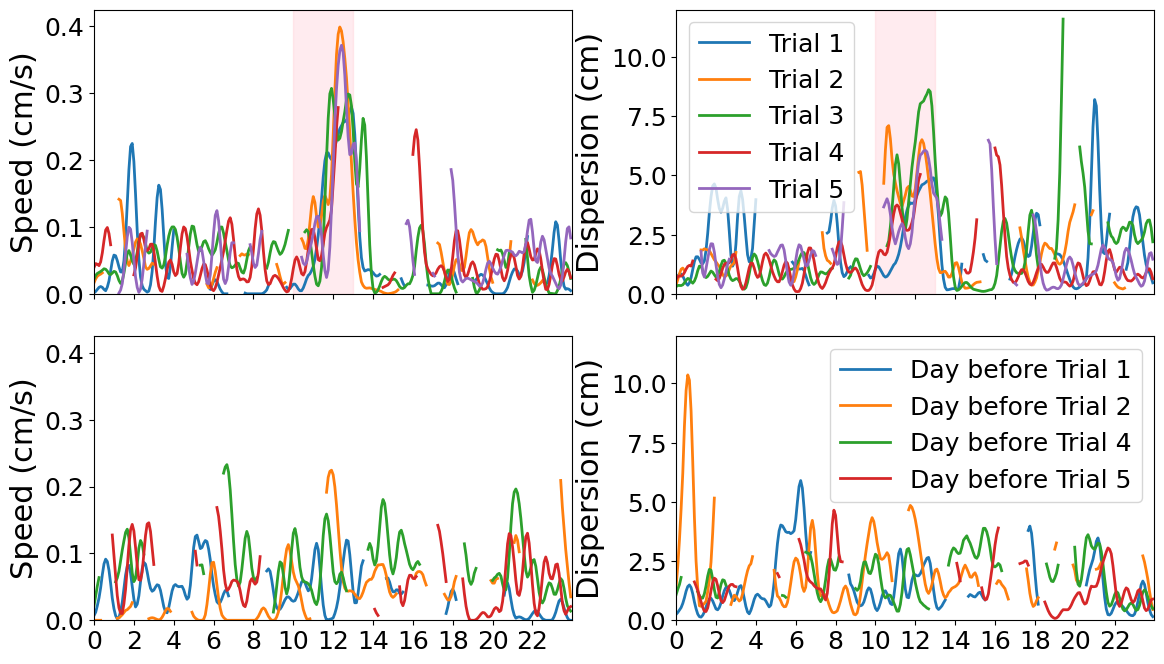

In [127]:

tpmetrics = ['Median speed','Dispersion (avg)']
tplabels = ['Speed (cm/s)', 'Dispersion (cm)']
f,ax = plt.subplots(2,2,sharex=True,sharey='col')
f.set_facecolor('white')
f.set_size_inches([12,7])
labelfontsize = 22
ticklabelfontsize = 18

## heat stress days
for i,daynum in enumerate(treatmentdays):
    dfday = df5min.loc[(df5min['Day number']==daynum)]
    tpx = dfday['timedivision']/288*24
    for m,a in zip(tpmetrics,ax[0]):
        tpy = dfday[m].values
        tpy = scipy.ndimage.gaussian_filter1d(tpy,sigma=2,truncate=2,mode='constant')
        a.plot(tpx,tpy,linewidth=2,label='Trial '+str(i+1))
        
## heat stress days
for daynum,i in zip(controldays,[0,1,3,4]):
    dfday = df5min.loc[(df5min['Day number']==daynum)]
    tpx = dfday['timedivision']/288*24
    for m,a in zip(tpmetrics,ax[1]):
        tpy = dfday[m].values
        tpy = scipy.ndimage.gaussian_filter1d(tpy,sigma=2,truncate=2,mode='constant')        
        a.plot(tpx,tpy,linewidth=2,label='Day before Trial '+str(i+1))  
    
    
# formatting
for a in ax[0]:
    a.axvspan(10,13,alpha=0.3,color='pink')
for i,lbl in enumerate(tplabels):
    for a in ax[:,i]:
        a.set_ylabel(lbl,fontsize=labelfontsize)
        
for a in ax.flatten():
    a.set_xlim([0,24])
    a.set_xticks(np.arange(0,24,2))
    a.tick_params(labelsize=ticklabelfontsize)
    
for a in ax[:,-1]:
    a.legend(fontsize=ticklabelfontsize)

ax[0,0].set_ylim([0,0.425])    # limit for speed
ax[0,1].set_ylim([0,12])  # limit for dispersion
plt.tight_layout(pad=2)
plt.savefig('../image-output/queen-movement.pdf')

# Plot trajectories for each day for the queen

In [ ]:
savefigures = True
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'queen2019trajectories-regthreshold.pdf')

daynum = 0
for daynum in range(bd.numdays-1):
    print(daynum)
    filename = resultsdir+'queentrajectory'+'_'+str(daynum).zfill(3)+'.hdf'
    df = pd.read_hdf(filename)
    day_uids = np.unique(df['uid']).astype(int).copy()  # this includes only bees that were alive this day - see '2019 - DBquery'    
    day = bd.alldaytimestamps[daynum]

    # load the comb structure
    comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))

    day_uids = np.unique(df['uid'])
    f,ax = bp.createnewimage(size=12)
    bp.showcomb(comb,ax=ax)
    if len(day_uids)>0:
        bee_uid = day_uids[0]
        dfsel = df[df['uid']==bee_uid]    
        bp.plotbee_xy(dfsel['x'],dfsel['y'],dfsel['camera'],ax=ax,rasterized=True)

    bp.showframe(ax)
    plt.suptitle('Queen, day '+str(daynum),fontsize=20)
    pdf.savefig(f) if savefigures else None
    # plt.show()
    plt.close()


pdf.close() if savefigures else None
